In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from gptools.stan import compile_model

import cmdstanpy
cmdstanpy.install_cmdstan()


CmdStan install directory: /root/.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


True

In [33]:
# !pip install nest_asyncio

In [34]:
import nest_asyncio
nest_asyncio.apply()

In [35]:
df = pd.read_csv('quality_nj2.csv')
#df = df[(df['YEAR_CODE'] == 1) & (df['MONTH_CODE'] == 1)]
from sklearn.preprocessing import LabelEncoder
encoder1, encoder2, encoder3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
df['RATING_EVENT_CODE'] = encoder1.fit_transform(df['RATING_EVENT'])
df['ENTRY_NAME_CODE'] = encoder2.fit_transform(df['ENTRY_NAME'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
# The categorical variables are now encoded with numerical values

In [36]:
plt_coords = df.groupby('PLT_ID_CODE')[['ROW','COL']].mean()
from scipy.spatial.distance import cdist
coords = np.array([plt_coords['ROW'].values, plt_coords['COL'].values])
distances = cdist(coords.T,coords.T, metric='euclidean')
distances
# The 'distance_matrix' is now an n x n NumPy array containing the Euclidean distances

array([[ 0.        ,  1.        ,  2.        , ..., 17.2626765 ,
        17.11724277, 17.02938637],
       [ 1.        ,  0.        ,  1.        , ..., 17.11724277,
        17.02938637, 17.        ],
       [ 2.        ,  1.        ,  0.        , ..., 17.02938637,
        17.        , 17.02938637],
       ...,
       [17.2626765 , 17.11724277, 17.02938637, ...,  0.        ,
         1.        ,  2.        ],
       [17.11724277, 17.02938637, 17.        , ...,  1.        ,
         0.        ,  1.        ],
       [17.02938637, 17.        , 17.02938637, ...,  2.        ,
         1.        ,  0.        ]])

In [37]:
plt_coords['ROW'].astype(int)

PLT_ID_CODE
0       1
1       1
2       1
3       1
4       1
       ..
262    18
263    18
264    18
265    18
266    18
Name: ROW, Length: 267, dtype: int64

In [38]:
import stan
#fourier model
padding = 5 # adjustable
num_rows = 18
num_cols = 15
stan_data_fourier = {"N": len(df["QUALITY"]),
             "I":len(df['RATING_EVENT'].unique()),
             "J":len(df['ENTRY_NAME'].unique()),
             "P":len(df['PLT_ID'].unique()),
             "M": 9,
             "ii": df["RATING_EVENT_CODE"].values+1,
             "jj": df["ENTRY_NAME_CODE"].values+1,
             "pp": df["PLT_ID_CODE"].values+1,
             "y": df["QUALITY"].values,
             "DIST": distances,
              # new values
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int)
              }
fourier_model = compile_model(stan_file="simple_fourier_model_4.stan", force_compile=True)

09:46:21 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
09:46:21 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_4.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_4
09:47:03 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_4


In [39]:
#fit = adv_model.sample(num_chains=1, num_samples=200)
fit = fourier_model.sample(stan_data_fourier)

09:47:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 4 |                                                                                                 | 00:00 Status

chain 1 |████▍                                                                                            | 00:00 Status
chain 2 |████▍                                                                                            | 00:00 Status


chain 4 |████▍                                                                                            | 00:00 Status


chain 4 |█████▊                                                          | 08:37 Iteration


10:29:41 - cmdstanpy - INFO - CmdStan done processing.
10:29:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'simple_fourier_model_4.stan', line 93, column 2 to column 27)
Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_4.stan', line 13, column 4 to column 40) (in 'simple_fourier_model_4.stan', line 104, column 1 to column 65)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_4.stan', line 13, column 4 to column 40) (in 'simple_fourier_model_4.stan', line 104, column 1 to column 65)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_4.stan', line 13, colu

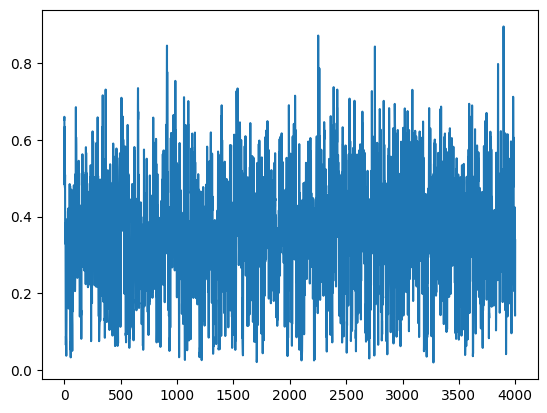

In [40]:
plt.plot(fit.length_scale)

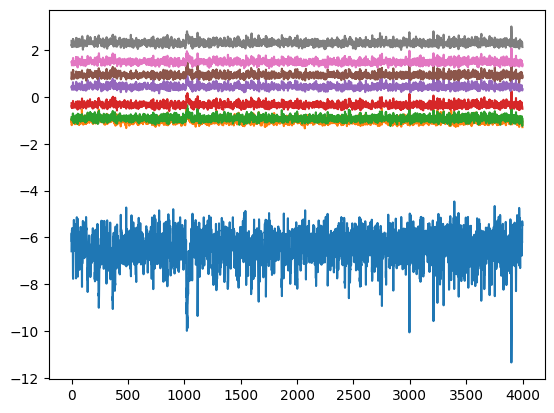

In [41]:
plt.plot(fit.tau_free)

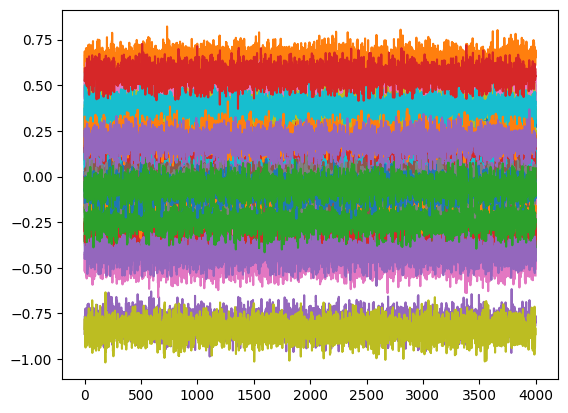

In [42]:
plt.plot(fit.beta_free)

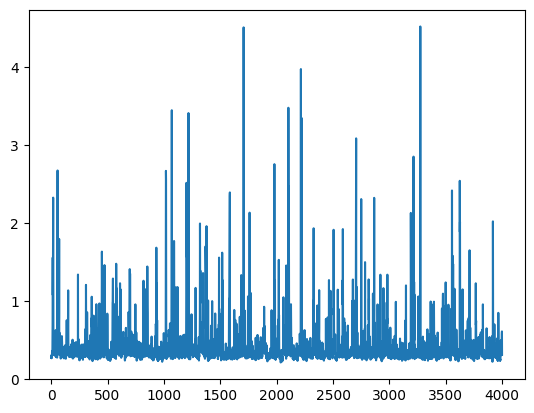

In [43]:
plt.plot(fit.alpha)

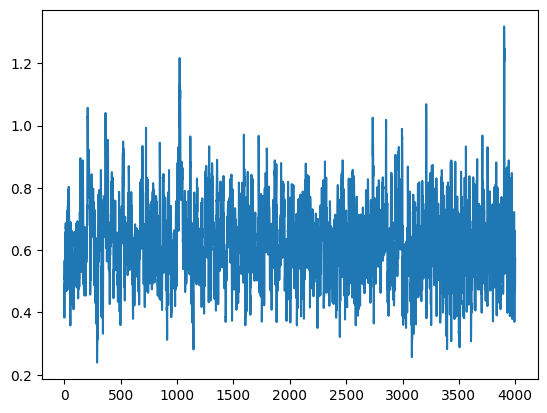

In [44]:
plt.plot(fit.mu)

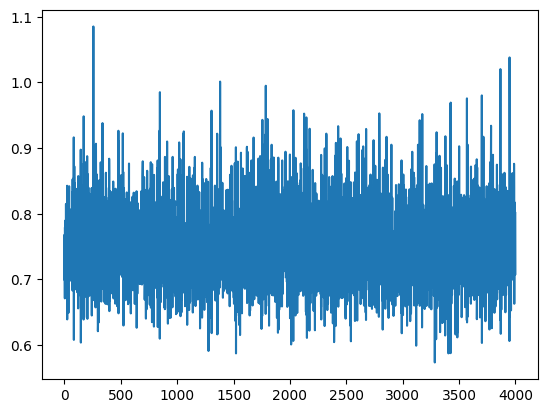

In [45]:
plt.plot(fit.sigma)

<Axes: ylabel='Density'>

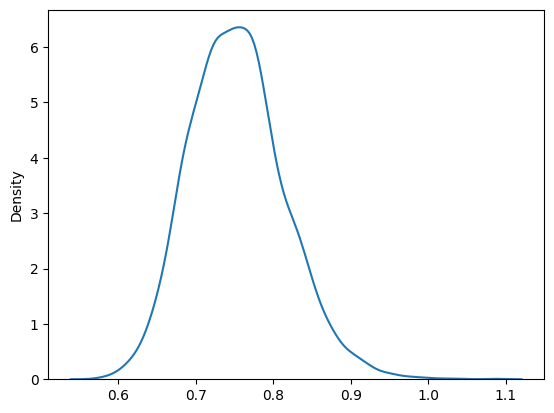

In [46]:
sns.kdeplot(fit.sigma)

<Axes: ylabel='Density'>

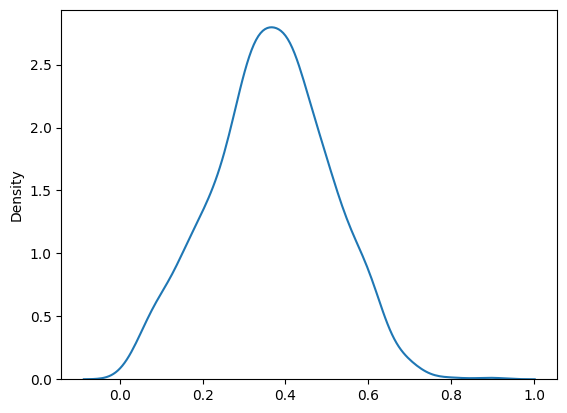

In [71]:
sns.kdeplot(fit.length_scale[3000:4000])

In [54]:
fit.plot[:,1].shape

(4000,)

In [55]:
fit.plot.mean(axis=0).shape

(267,)

<Axes: >

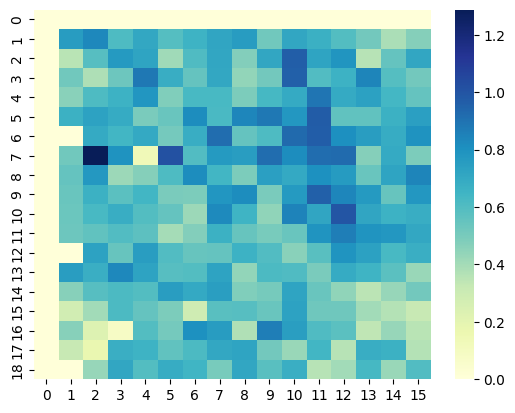

In [60]:
PLT_ROW = plt_coords["ROW"].astype(int)
PLT_COL =plt_coords["COL"].astype(int)
mean_matrix = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix[PLT_ROW, PLT_COL] = fit.plot.mean(axis=0)
sns.heatmap(mean_matrix, cmap="YlGnBu")

<Axes: >

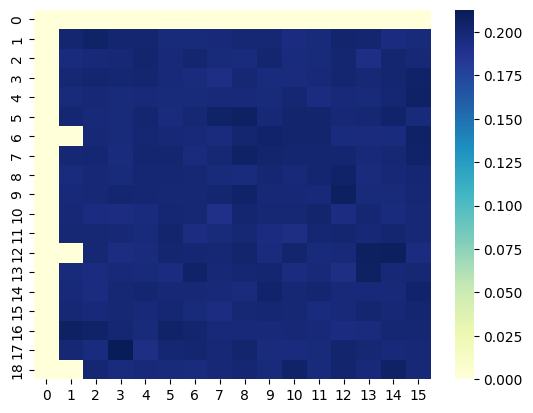

In [62]:
std_matrix = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
std_matrix[PLT_ROW, PLT_COL] = fit.plot.std(axis=0)
sns.heatmap(std_matrix, cmap="YlGnBu")

In [73]:
fourier_model_exp_quad = compile_model(stan_file="simple_fourier_model_5.stan", force_compile=True)

21:42:54 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
21:42:54 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_5.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_5
21:44:06 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_5


In [76]:
#fit = adv_model.sample(num_chains=1, num_samples=200)
fit_exp_quad = fourier_model.sample(stan_data_fourier)

22:06:21 - cmdstanpy - INFO - CmdStan start processing




chain 1 |                                                                      | 00:00 Status




chain 2 |                                                                      | 00:00 Status





chain 3 |                                                                      | 00:00 Status






chain 4 |                                                                      | 00:00 Status





chain 3 |███▏                                                                  | 00:00 Status



chain 1 |███▏                                                                  | 00:00 Status




chain 2 |███▏                                                                  | 00:00 Status






chain 4 |███▏                                                                  | 00:00 Status




chain 2 |███▎                                 | 08:44 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 3 |███▎                                 | 09:08


22:52:52 - cmdstanpy - INFO - CmdStan done processing.
22:52:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'simple_fourier_model_4.stan', line 93, column 2 to column 27)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'simple_fourier_model_4.stan', line 93, column 2 to column 27)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_4.stan', line 13, column 4 to column 40) (in 'simple_fourier_model_4.stan', line 104, column 1 to column 65)
Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_4.stan', line 13, column 4 to column 40) (in 'simple_fourier_model_4.stan', line 104, column 1 to column 65)
	Exception: Exception: categorical_lpmf: Probabilities 

22:52:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Text(0.5, 1.0, 'Maern 3/2 Plot Covariance')

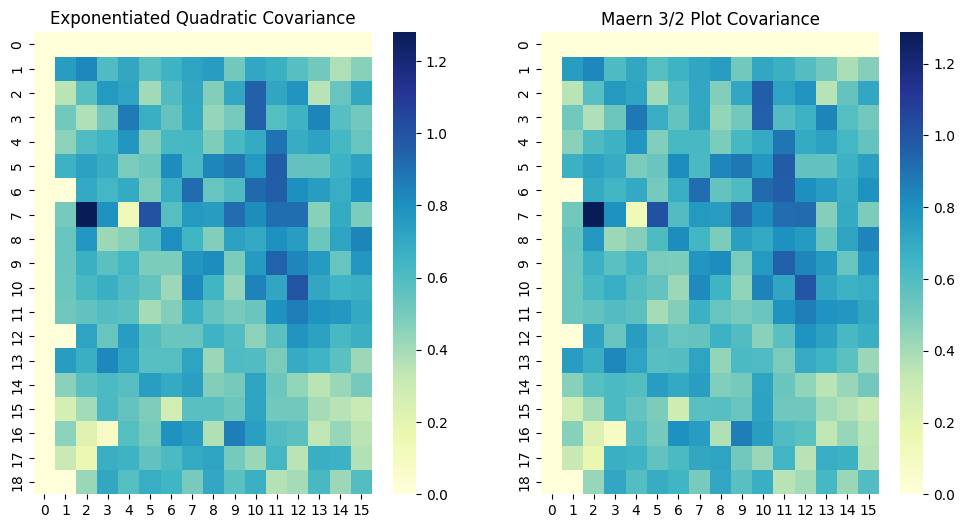

In [79]:
mean_matrix_exp_quad = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix_exp_quad[PLT_ROW, PLT_COL] = fit_exp_quad.plot.mean(axis=0)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(mean_matrix_exp_quad, cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Exponentiated Quadratic Covariance")
sns.heatmap(mean_matrix, cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Maern 3/2 Plot Covariance")

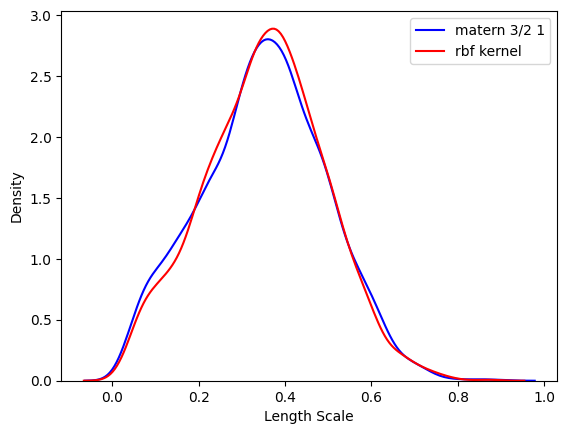

In [81]:
sns.kdeplot(fit.length_scale, color='blue', label='matern 3/2 1')

# Plot the second KDE line
sns.kdeplot(fit_exp_quad.length_scale, color='red', label='rbf kernel')

# Customize the plot
plt.xlabel('Length Scale')
plt.ylabel('Density')
plt.legend()


In [82]:
fit_exp_quad.entry

array([[-0.0501333 ,  0.162439  ,  1.11251   , ..., -0.0158913 ,
         0.00684122, -0.719072  ],
       [-0.406044  ,  0.382863  ,  1.12521   , ...,  0.0256771 ,
         0.14865   , -0.621808  ],
       [ 0.0618745 ,  0.336619  ,  1.26492   , ..., -0.0848512 ,
         0.0414836 , -0.174872  ],
       ...,
       [ 0.175744  ,  0.687111  ,  0.955491  , ...,  0.0362339 ,
         0.60087   , -0.203068  ],
       [ 0.136662  ,  0.606996  ,  1.84882   , ...,  0.342649  ,
         0.326278  , -0.146525  ],
       [ 0.195493  ,  0.765944  ,  1.42252   , ...,  0.325812  ,
         0.246883  , -0.502298  ]])